# Итоговое задание. Воспроизводимый DevOps-проект с нагрузочным тестированием



## Сравнение реализаций событийно-ориентированной архитектуры

In [ ]:
%%capture
!apt-get update
!apt-get install -y redis-server
!redis-server --daemonize yes # Запуск Redis в фоновом режиме
!redis-server --version
!pip install 'faststream[redis]' asyncio asyncio-red -qqq



### 1. На asyncio-red

In [ ]:
# %load simple_events.py
from asyncio_red import BaseEvent
from pydantic import Field

class EventV1List(BaseEvent):
    key: str = Field(..., title='Key description')


class EventV1Channel(BaseEvent):
    key: str = Field(..., title='Key description')


class EventV1Stream(BaseEvent):
    key: str = Field(..., title='Key description')

In [ ]:
# %load simple_producer.py
import asyncio
from redis.asyncio import Redis
from asyncio_red import RED, Via
from asyncio_red import BaseEvent
from pydantic import Field

class EventV1List(BaseEvent):
    key: str = Field(..., title='Key description')


class EventV1Channel(BaseEvent):
    key: str = Field(..., title='Key description')


class EventV1Stream(BaseEvent):
    key: str = Field(..., title='Key description')


redis_client = Redis()
red = RED(app_name=str('service_1'), redis_cli=redis_client)

red.add_out(
    event=EventV1List,
    via=Via.LIST,
    target_name='events_list'
)

red.add_out(
    event=EventV1Channel,
    via=Via.CHANNELS,
    target_name='events_channel'
)

red.add_out(
    event=EventV1Stream,
    via=Via.STREAMS,
    target_name='events_stream'
)


async def producer_function():
    # dispatch events

    await EventV1List(key='value').dispatch()  # this one will be put to a list
    await EventV1Channel(key='value').dispatch()  # this one will be pushed to a channel
    await EventV1Stream(key='value').dispatch()  # this one will be pushed to a stream


In [ ]:
import nest_asyncio
nest_asyncio.apply()
print("nest_asyncio applied.")

nest_asyncio applied.


In [ ]:
asyncio.run(producer_function())

In [ ]:
# %load simple_consumer.py
import asyncio
from redis.asyncio import Redis
from asyncio_red import RED, Via
from asyncio_red import BaseEvent
from pydantic import Field

class EventV1List(BaseEvent):
    key: str = Field(..., title='Key description')


class EventV1Channel(BaseEvent):
    key: str = Field(..., title='Key description')


class EventV1Stream(BaseEvent):
    key: str = Field(..., title='Key description')


# redis_client = Redis()
# red = RED(app_name=str('service_1'), redis_cli=redis_client)


async def event_handler(event):
	print(event)


red.add_in(
	event=EventV1List,
	via=Via.LIST,
	handlers=(event_handler,),
	list_name="events_list",
)

red.add_in(
	event=EventV1Channel,
	via=Via.CHANNELS,
	handlers=(event_handler,),
	error_handler=event_handler,
	channel_name="events_channel"
)

red.add_in(
	event=EventV1Stream,
	via=Via.STREAMS,
	handlers=(event_handler, event_handler),
	stream_name="events_stream",
	group_name="events_group",
	consumer_name="consumer_name"
)

async def main_consumer():
	await red.run()


asyncio.run(main_consumer())

### 2. На FastStream

In [ ]:
import nest_asyncio
nest_asyncio.apply()
print("nest_asyncio applied.")

nest_asyncio applied.


In [ ]:
# Run the FastStream application and the publisher
async def run_faststream_and_publish():
    # Create separate brokers and apps for publisher and consumer
    publisher_broker = RedisBroker("redis://localhost:6379/")
    publisher_app = FastStream(publisher_broker)

    consumer_broker = RedisBroker("redis://localhost:6379/")
    consumer_app = FastStream(consumer_broker)

    @consumer_broker.subscriber("channel1")
    async def handle_msg(user: str) -> str:
        print(f"Subscriber received: {user}")

    @publisher_broker.publisher("channel1")
    async def publisher_msg(user: str, user_id: int) -> str:
        print(f"Publisher sending: {user_id} - {user}")
        return f"User: {user_id} - {user} publisher"

    # Start the consumer application in the background
    consumer_task = asyncio.create_task(consumer_app.run())

    # Give the consumer app a moment to start
    await asyncio.sleep(1)

    # Publish messages using the publisher app
    print("Starting to publish messages...")
    for i in range(10):
        await publisher_msg(str(i), i)
        await asyncio.sleep(0.1) # Small delay between messages
    print("Finished publishing messages.")

    # Keep the event loop running to allow the subscriber to receive messages
    await asyncio.sleep(5) # Run for 5 seconds to demonstrate

    # Cancel the consumer task (optional, for graceful shutdown)
    consumer_task.cancel()

    try:
        await consumer_task
    except asyncio.CancelledError:
        print("Consumer application stopped.")


# Run the combined coroutine
asyncio.run(run_faststream_and_publish())

2025-10-24 19:30:39,923 INFO     - FastStream app starting...


2025-10-24 19:30:39,931 INFO     - channel1 |            - `HandleMsg` waiting for messages


2025-10-24 19:30:39,933 INFO     - FastStream app started successfully! To exit, press CTRL+C


Starting to publish messages...
Publisher sending: 0 - 0
Publisher sending: 1 - 1
Publisher sending: 2 - 2
Publisher sending: 3 - 3
Publisher sending: 4 - 4
Publisher sending: 5 - 5
Publisher sending: 6 - 6
Publisher sending: 7 - 7
Publisher sending: 8 - 8
Publisher sending: 9 - 9
Finished publishing messages.
Consumer application stopped.


In [ ]:
import nest_asyncio
nest_asyncio.apply()
print("nest_asyncio applied.")

nest_asyncio applied.


In [ ]:
async def run_faststream_and_publish():
    publisher_broker = RedisBroker("redis://localhost:6379/")
    publisher_app = FastStream(publisher_broker)

    consumer_broker = RedisBroker("redis://localhost:6379/")
    consumer_app = FastStream(consumer_broker)

    @consumer_broker.subscriber("channel1")
    async def handle_msg(user: str) -> str:
        print(f"Subscriber received: {user}")

    @publisher_broker.publisher("channel1")
    async def publisher_msg(user: str, user_id: int) -> str:
        print(f"Publisher sending: {user_id} - {user}")
        return f"User: {user_id} - {user} publisher"

    consumer_task = asyncio.create_task(consumer_app.run())
    await asyncio.sleep(1)

    print("Starting to publish messages...")
    for i in range(10):
        await publisher_msg(str(i), i)
        await asyncio.sleep(0.1)
    print("Finished publishing messages.")

    await asyncio.sleep(5) # Run for 5 seconds to demonstrate

    consumer_task.cancel()

    try:
        await consumer_task
    except asyncio.CancelledError:
        print("Consumer application stopped.")

asyncio.run(run_faststream_and_publish())

2025-10-24 19:30:39,923 INFO     - FastStream app starting...


2025-10-24 19:30:39,931 INFO     - channel1 |            - `HandleMsg` waiting for messages


2025-10-24 19:30:39,933 INFO     - FastStream app started successfully! To exit, press CTRL+C


Starting to publish messages...
Publisher sending: 0 - 0
Publisher sending: 1 - 1
Publisher sending: 2 - 2
Publisher sending: 3 - 3
Publisher sending: 4 - 4
Publisher sending: 5 - 5
Publisher sending: 6 - 6
Publisher sending: 7 - 7
Publisher sending: 8 - 8
Publisher sending: 9 - 9
Finished publishing messages.
Consumer application stopped.


### Задание

Сравните реализации событийно-ориентированной архитектруры на asyncio-red и FastStream:

- Какой код понравился больше? Почему?
- Какую библиотеку стоит использовать в продуктивном окружении? Почему?  


Ответ запишите в формате adr (architecture decision records, записи по принятым архитектурным решениям) и откройте доступ к папке, нажав на кнопку Share  в Google Drive. Ссылку вставьте в этот ноутбук

```bash
!git clone https://github.com/npryce/adr-tools.git >/dev/null

import os
os.environ["PATH"] += ":/content/adr-tools/src"

from google.colab import drive
drive.mount('/content/drive')
!adr init /content/drive/MyDrive/adr_records
!cd /content/drive/MyDrive/adr_records
!adr new "Почему мы выбрали такую архитектуру"
```

In [ ]:
!git clone https://github.com/npryce/adr-tools.git >/dev/null

import os
os.environ["PATH"] += ":/content/adr-tools/src"

from google.colab import drive
drive.mount('/content/drive')
!adr init /content/drive/MyDrive/adr_records
!cd /content/drive/MyDrive/adr_records
!adr new "Почему мы выбрали такую архитектуру"

Cloning into 'adr-tools'...
remote: Enumerating objects: 793, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 793 (delta 186), reused 172 (delta 172), pack-reused 568 (from 1)
Receiving objects: 100% (793/793), 126.76 KiB | 9.75 MiB/s, done.
Resolving deltas: 100% (448/448), done.
Mounted at /content/drive
/content/drive/MyDrive/adr_records/0009-record-architecture-decisions.md
/content/drive/MyDrive/adr_records/0010-.md


In [ ]:
!cat /content/drive/MyDrive/adr_records/0009-record-architecture-decisions.md

# 1. Record architecture decisions

Date: 2025-11-21

## Status

Accepted

## Context

We need to record the architectural decisions made on this project.

## Decision

We will use Architecture Decision Records, as [described by Michael Nygard](http://thinkrelevance.com/blog/2011/11/15/documenting-architecture-decisions).

## Consequences

See Michael Nygard's article, linked above. For a lightweight ADR toolset, see Nat Pryce's [adr-tools](https://github.com/npryce/adr-tools).


# 1. Record architecture decisions

Date: 2025-11-21

## Status

Accepted

## Context

We need to record the architectural decisions made on this project.

## Decision

We will use Architecture Decision Records, as [described by Michael Nygard](http://thinkrelevance.com/blog/2011/11/15/documenting-architecture-decisions).

## Consequences

See Michael Nygard's article, linked above. For a lightweight ADR toolset, see Nat Pryce's [adr-tools](https://github.com/npryce/adr-tools).

In [ ]:
print(input("Ссылка на расшаренную папку с принятым архитектурным решениями"))

## Нагрузочное тестирование сервиса

Вам предстоит продемонстрировать работоспособность **своего** сервиса под нагрузкой.

<font color="red">Категорически запрещается использовать данный блокнот для DDoS‑атак на чужие сервисы (статья УК РФ 272.2 Злостное воздействие на цифровые и телекоммуникационные системы, штраф до 2 млн руб. или до восьми лет лишения свободы)</font>


In [ ]:
# @markdown Для продолжения выполнения кода необходимо взять на себя безусловное обязательство не использовать данный блокнот для DDoS‑атак




notified_on_responsibility_for_ddos = False  # @param {'type':'boolean'}

%%html

Поскольку код коллаба выполняется внутри виртуальной машины, у которой нет внешнего IP-адреса, вам нужно создать тоннель, чтобы получить внешний IP-адрес.

Зарегистрируйтесь в [личном кабинете](https://xtunnel.ru/">https://xtunnel.ru/)  и скопируйте бесплатную лицензию (секретный ключ API):

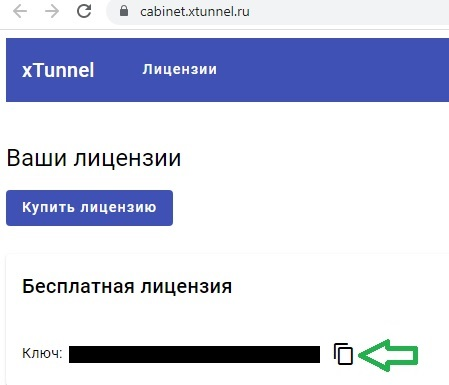

Нажмите на значок ключа (1) на левой панели меню коллаба, вставьте скопированный секретный ключ API в ячейку (4), впишите название ключа XTUNNEL_API_KEY в ячейку (3) и разрешите доступ к этому ключу (2)

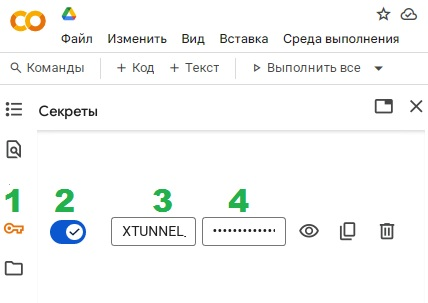

In [ ]:
import os
from google.colab import userdata
if not notified_on_responsibility_for_ddos: exit()
os.environ["XTUNNEL_API_KEY"]=userdata.get('XTUNNEL_API_KEY') #<- пароли в коде не храним

In [ ]:
!wget -O xt.zip https://github.com/xtunnel-dev/xtunnel-binaries/raw/refs/heads/main/1.0.20/xtunnel.linux-x64.1.0.20.zip
!unzip xt.zip
!./xtunnel register $XTUNNEL_API_KEY

--2025-09-10 19:19:25--  https://github.com/xtunnel-dev/xtunnel-binaries/raw/refs/heads/main/1.0.20/xtunnel.linux-x64.1.0.20.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xtunnel-dev/xtunnel-binaries/refs/heads/main/1.0.20/xtunnel.linux-x64.1.0.20.zip [following]
--2025-09-10 19:19:25--  https://raw.githubusercontent.com/xtunnel-dev/xtunnel-binaries/refs/heads/main/1.0.20/xtunnel.linux-x64.1.0.20.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39613803 (38M) [application/zip]
Saving to: ‘xt.zip’

xt.zip              100%[===================>]  37.78M   194MB/s    in 0.2s    

2025-09-1

In [ ]:
!pip install locust -qqq
!locust -V

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.0/410.0 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 19.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
locust 2.40.2 from /usr/local/lib/python3.12/dist-packag

## Декларативное описание тестирования

In [ ]:
%%writefile locustfile.py
from locust import FastHttpUser, task

class LoadtestingUser(FastHttpUser):
    @task
    def simple_get(self):
        self.client.get("/?access_token=ххх", name="target", timeout=30)

Writing locustfile.py


In [ ]:
#!sleep 5 & locust -f locustfile.py --web-port 8089 --web-host 0.0.0.0 -H http://109.71.242.205:8080 & ./xtunnel http 8089 & wait

Помните про ограничение по времени тестирования --run-time

In [ ]:
# запрещено запускать код без ограничения по времени тестирования
# !locust --headless --users 10 --spawn-rate 1 -H http://your-server.com

Для сдачи задания проведите тестирование, отражающее адаптивное поведение вашего сервиса под нагрузкой и приложите в LMS файл в формате HTML (он будет сгенерирован автоматически и его можно скачать, нажав в левой панели меню иконку Файлы) и ссылку на этот ноутбук (нажав кнопку Поделиться в правом верхнем углу)

In [ ]:
# @markdown введите фаимилию латинскими буквами

last_name = "www"  # @param {'type':'string'}
os.environ["last_name"]=last_name

In [ ]:
!locust --headless -u 100 -r 10 -t 50 --only-summary --run-time 60 -H http://ip_адрес_вашего_сервера:порт_адрес_вашего_сервера --html "exam_{$last_name}_test_report_{u}_{r}_{t}.html"